# 데이터 준비

In [1]:
!wget https://github.com/dhrim/deep_learning_data/raw/master/dogs_cats_yolo_labeled.zip

--2022-01-25 05:38:58--  https://github.com/dhrim/deep_learning_data/raw/master/dogs_cats_yolo_labeled.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/deep_learning_data/master/dogs_cats_yolo_labeled.zip [following]
--2022-01-25 05:39:05--  https://raw.githubusercontent.com/dhrim/deep_learning_data/master/dogs_cats_yolo_labeled.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5478153 (5.2M) [application/zip]
Saving to: ‘dogs_cats_yolo_labeled.zip’

dogs_cats_yolo_labe 100%[===================>]   5.22M  --.-KB/s    in 0.04s   

2022-01-25 05:39:05 (137 MB/s) - ‘dogs_cats_yolo_labele

In [2]:
!unzip dogs_cats_yolo_labeled.zip

Archive:  dogs_cats_yolo_labeled.zip
   creating: dogs_cats_yolo_labeled/
  inflating: dogs_cats_yolo_labeled/cat.99.jpg  
  inflating: dogs_cats_yolo_labeled/cat.99.xml  
  inflating: dogs_cats_yolo_labeled/cat.990.jpg  
  inflating: dogs_cats_yolo_labeled/cat.990.xml  
  inflating: dogs_cats_yolo_labeled/cat.9900.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9900.xml  
  inflating: dogs_cats_yolo_labeled/cat.9901.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9901.xml  
  inflating: dogs_cats_yolo_labeled/cat.9902.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9902.xml  
  inflating: dogs_cats_yolo_labeled/cat.9903.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9903.xml  
  inflating: dogs_cats_yolo_labeled/cat.9904.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9904.xml  
  inflating: dogs_cats_yolo_labeled/cat.9905.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9905.xml  
  inflating: dogs_cats_yolo_labeled/cat.9906.jpg  
  inflating: dogs_cats_yolo_labeled/cat.9906.xml  
  inflating: d

# 이미지 파일 읽기

In [5]:
import glob

file_list = glob.glob("dogs_cats_yolo_labeled/*.jpg")
print(len(file_list))
print(file_list[:3])

222
['dogs_cats_yolo_labeled/dog.992.jpg', 'dogs_cats_yolo_labeled/dog.9938.jpg', 'dogs_cats_yolo_labeled/dog.9937.jpg']


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [7]:
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

In [8]:
dog_images = []
cat_images = []
for file_name in file_list:
    image = plt.imread(file_name)
    image = cv2.resize(image, (224,224))
    image = preprocessor(image)
    if "/dog" in file_name:
        dog_images.append(image)
    else:
        cat_images.append(image)

In [9]:
dog_images = np.array(dog_images)
cat_images = np.array(cat_images)
print(len(dog_images))
print(len(cat_images))

111
111


# Data Generator

In [10]:
BATCH_SIZE = 32

In [11]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence
from abc import *
import traceback

class DataGenerator(Sequence):

  def __init__(self, dog_images, cat_images, batch_size=BATCH_SIZE, shuffle=True):
    self.images = [ dog_images, cat_images ]
    self.batch_size = batch_size
    self.shuffle=shuffle
    self.on_epoch_end()

  def __len__(self):
    return math.ceil((len(self.images[0])+len(self.images[1]) )/ self.batch_size)

  def __getitem__(self, idx):
    batch_x0 = []
    batch_x1 = []
    batch_y = []
    for i in range(self.batch_size):
        c0, c1 = np.random.randint(2, size=2)
        batch_x0.append(self.images[c0][np.random.randint(len(self.images[c0]))])
        batch_x1.append(self.images[c1][np.random.randint(len(self.images[c1]))])
        batch_y.append(int(c0==c1))
    return (np.array(batch_x0), np.array(batch_x1)), np.array(batch_y)

  def on_epoch_end(self):
    pass


In [12]:
data_generator = DataGenerator(dog_images, cat_images)

(32, 224, 224, 3)


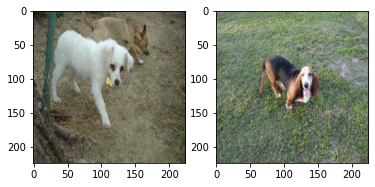

1


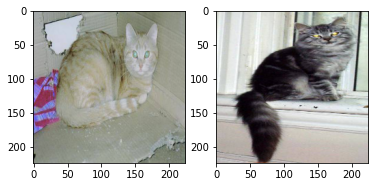

1


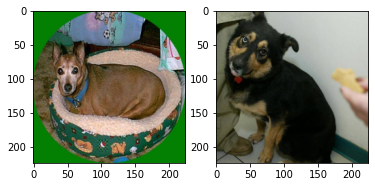

1


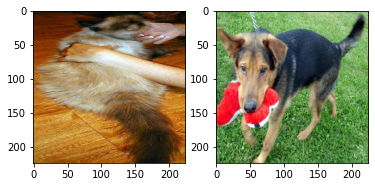

0


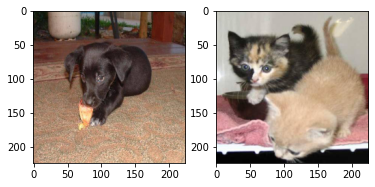

0


In [13]:
batch_x, batch_y = data_generator.__getitem__(0)
print(batch_x[0].shape)
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(batch_x[0][i])
    plt.subplot(1,2,2)
    plt.imshow(batch_x[1][i])
    plt.show()
    print(batch_y[i])


# 모델 정의와 학습

In [14]:
from tensorflow.python.keras.layers.merge import Concatenate
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Input, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

branch_input1 = Input((224,224,3))
x = conv_layers(branch_input1)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
branch_output1 = Dense(32, activation="relu", name="branch1_output")(x)

branch_input2 = Input((224,224,3))
x = conv_layers(branch_input2)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
branch_output2 = Dense(32, activation="relu", name="branch2_output")(x)


merged = Concatenate()([branch_output1, branch_output2])
x = Dense(10, activation="relu")(merged)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=(branch_input1, branch_input2), outputs=outputs)
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['acc'])
model.encoder = Model(inputs=[branch_input1], outputs=[branch_output1])

In [15]:
history = model.fit(data_generator, epochs=50)

Epoch 1/50
7/7 [==============================] - 19s 69ms/step - loss: 1.8970 - acc: 0.4821
Epoch 2/50
7/7 [==============================] - 0s 69ms/step - loss: 1.4740 - acc: 0.5893
Epoch 3/50
7/7 [==============================] - 0s 70ms/step - loss: 0.8896 - acc: 0.5223
Epoch 4/50
7/7 [==============================] - 1s 69ms/step - loss: 0.7114 - acc: 0.5312
Epoch 5/50
7/7 [==============================] - 0s 70ms/step - loss: 0.6999 - acc: 0.5179
Epoch 6/50
7/7 [==============================] - 0s 69ms/step - loss: 0.7407 - acc: 0.4777
Epoch 7/50
7/7 [==============================] - 0s 69ms/step - loss: 0.6836 - acc: 0.4866
Epoch 8/50
7/7 [==============================] - 0s 70ms/step - loss: 0.7001 - acc: 0.4598
Epoch 9/50
7/7 [==============================] - 0s 69ms/step - loss: 0.6883 - acc: 0.4777
Epoch 10/50
7/7 [==============================] - 1s 70ms/step - loss: 0.7057 - acc: 0.5402
Epoch 11/50
7/7 [==============================] - 1s 71ms/step - loss: 0.7776

# 영상 인코딩

In [16]:
images = np.vstack([dog_images, cat_images])
codes = model.encoder(images)

# 가까운 영상 찾기

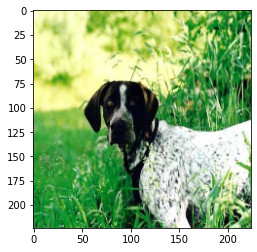

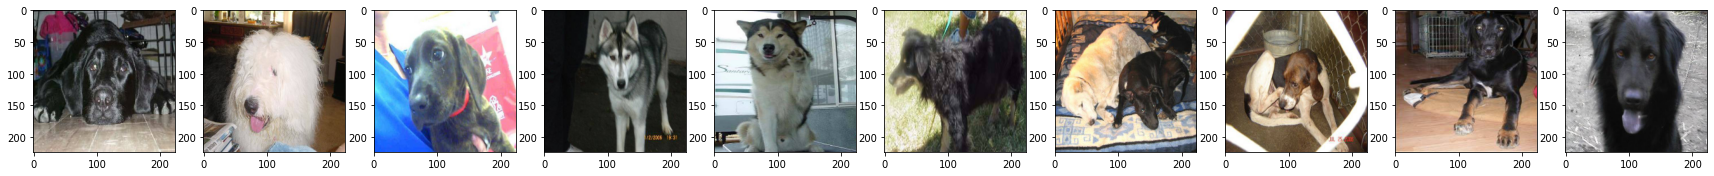

In [17]:
from scipy.spatial import distance

target_index = 5
target_image = images[target_index]
target_code = codes[target_index]

distances = [distance.euclidean(target_code, code) for code in codes]
similar_index = np.argsort(distances)

plt.imshow(target_image)
plt.show()
n = 10
plt.figure(figsize=(30,3))
for i in range(1,n+1):
    plt.subplot(1,n,i)
    plt.imshow(images[similar_index[i]])
plt.show()


# DCI KNN 

빠른 최근접 검색 알고리즘. https://github.com/ke-li/dci-knn



In [25]:
import numpy as np
import copy
import bisect
from collections import defaultdict

class Dci:
  @staticmethod
  def get_proj_norm_vec(dim):
    a = np.random.random(dim) * 2 - 1
    return a / np.linalg.norm(a)

  @staticmethod
  def get_proj_norm_vecs(dim, m):
    return np.array([Dci.get_proj_norm_vec(dim) for _ in range(m)])

  @staticmethod
  def get_proj_point(vector, point):
    """
    point가 vector에 proj된 포인트가 y라면,
    a*vector = constant * y에서 비교 가능한 a를 구한다.
    """
    return sum(vector * point)

  def _get_projected_points(self):
    """
    각 쿼리선에 대해서,
    (카테고리, vector 크기)를 크기에 대해 정렬하여 구한다.
    """
    data_full = []
    data_only = []
    # For Query lines,
    for vec in self.query_lines:
      temp = []
      # Project all points to line
      for category, point in self.points:
        temp.append((category, Dci.get_proj_point(vec, point)))
      data = sorted(temp, key=lambda x: x[1])
      data_full.append(data)
      data_only.append([d[1] for d in data])
    return data_full, data_only


  def __init__(self, point_map, query_line_count=3):
    self.dim = list(point_map.values())[0].shape[0]
    self.total_scattered_point_count = len(point_map.keys())
    self.point_map = point_map
    self.points = list(point_map.items())
    self.query_line_count = query_line_count
    self.query_lines = Dci.get_proj_norm_vecs(self.dim, query_line_count)
    self.data_full, self.data_key = self._get_projected_points()

  def query(self, point, highest_k=5):
    """
    가장 가까울 highest_k만큼의 point를 구한다.
    """
    if highest_k > self.total_scattered_point_count:
      highest_k = self.total_scattered_point_count
    this_projected = [Dci.get_proj_point(vec, point) for vec in self.query_lines]
    
    appear_dict = defaultdict(int)
    double_pointer_dict = dict()

    result = []
    flag = False

    for i in range(self.query_line_count):
      find = bisect.bisect(self.data_key[i], this_projected[i])
      if find == self.total_scattered_point_count: find -= 1

      category = self.data_full[i][find][0]
      appear_dict[category] += 1

      double_pointer_dict[i] = (find, find)
      if appear_dict[category] == self.query_line_count:
        result.append(category)
        if len(result) == highest_k:
          flag = True
          break

    for _ in range(self.total_scattered_point_count):  
      if flag: break
      for i in range(self.query_line_count):
        key = self.data_key[i]
        full = self.data_full[i]

        left, right = double_pointer_dict[i]
        # left - 1 right + 1 중 하나를 선택

        if left > 0:
          val1 = abs(this_projected[i] - key[left-1])
        else:
          val1 = float('inf')
        if right < self.total_scattered_point_count - 1:
          val2 = abs(this_projected[i] - key[right+1])
        else:
          val2 = float('inf')

        if val1 <= val2:
          idx = left - 1
          double_pointer_dict[i] = (idx, right)
        else:
          idx = right + 1
          double_pointer_dict[i] = (left, idx)

        category = full[idx][0]
        appear_dict[category] += 1

        if appear_dict[category] == self.query_line_count:
          result.append(category)
          if len(result) == highest_k:
            flag = True
            break

    return sorted(list(
      map(
        lambda c: (c, np.linalg.norm(self.point_map[c] - point, ord=2)),
        result
      )
    ), key=lambda x: x[1])

class AnchorDci(Dci):
  def __init__(self, anchors, query_line_count=10):
    points = dict()
    for k, v in anchors.items():
      points[k] = v['mean']
    super().__init__(points, query_line_count)

In [32]:
point_dic = {i:v for i, v in enumerate(codes)}
dci = Dci(point_dic)
query_result = dci.query(target_code, 11)

In [34]:
query_result

[(5, 0.0),
 (51, 67.07185),
 (26, 78.51816),
 (64, 79.13707),
 (37, 89.21991),
 (93, 98.10553),
 (32, 110.455894),
 (104, 110.708405),
 (109, 123.71719),
 (82, 123.79128),
 (59, 124.889626)]

In [35]:
similar_index

[51, 26, 64, 37, 93, 32, 104, 109, 82, 59]

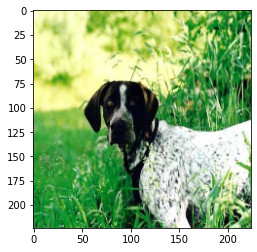

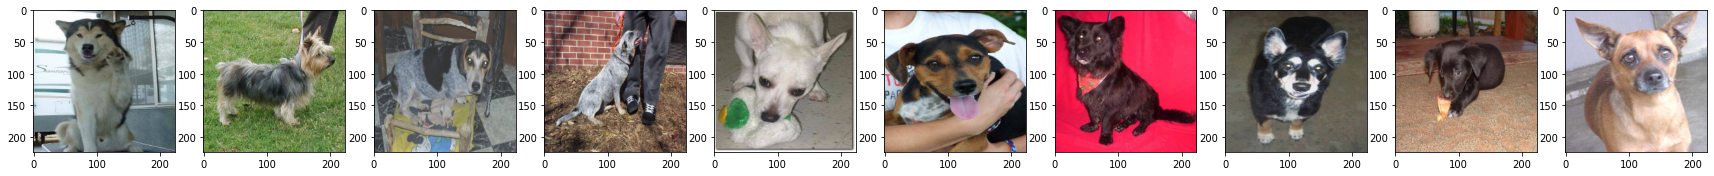

In [38]:
similar_index = [i for i, d in query_result]

plt.imshow(target_image)
plt.show()
n = 10
plt.figure(figsize=(30,3))
for i in range(1,n+1):
    plt.subplot(1,n,i)
    plt.imshow(images[similar_index[i]])
plt.show()
